# Citrus Leaves Detection

In [24]:
#Load Data
#!pip install opencv-python
#!pip install Keras-Preprocessing
#!pip install Keras
#!pip install tensorflow
#!pip install matplotlib
#!pip install pytest-shutil
#!pip install scikit-learn
#!pip install more-itertools
!pip install graphviz
!pip install pydot
from keras_preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.utils import Sequence
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping

import numpy as np 
import cv2 
import os
import shutil
from keras.models import load_model

## Classes

In [7]:
classes=['Black spot', 'canker', 'greening', 'healthy']

## Data Agumentation

### Creating folder to save traiving&val data and Predition data/testing

In [9]:
#creting  test data falde
def createFolder(dirName):
     #if you don't have data_set/Citrus diretory please create it
    if not os.path.exists(os.path.join(dirName)):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")

    #creting folders in test data  
    dirName1 = dirName+'/' 
    for folder in classes:
        dirName1=dirName1+folder
        if not os.path.exists(dirName1):
            os.mkdir(dirName1)
            print("Directory " , dirName1,  " Created ")
        else:    
            print("Directory " , dirName1 , " already exists")
        dirName1 = dirName+'/'
        
createFolder('data_set/Citrus/TestData')
createFolder('data_set/Citrus/Augmented')

Directory  data_set/Citrus/TestData  Created 
Directory  data_set/Citrus/TestData/Black spot  Created 
Directory  data_set/Citrus/TestData/canker  Created 
Directory  data_set/Citrus/TestData/greening  Created 
Directory  data_set/Citrus/TestData/healthy  Created 
Directory  data_set/Citrus/Augmented  Created 
Directory  data_set/Citrus/Augmented/Black spot  Created 
Directory  data_set/Citrus/Augmented/canker  Created 
Directory  data_set/Citrus/Augmented/greening  Created 
Directory  data_set/Citrus/Augmented/healthy  Created 


### Generating data

In [10]:
#data augmentation
augmentor_datagen = ImageDataGenerator( 
    rotation_range=45,      # random rotaition of image is between 0-45 degree 
    width_shift_range=0.1,  #shifts image horizontal
    height_shift_range=0.1, #shifts image vertical
    zoom_range=0.15,        #zoom image
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",   # ---abbc- to aaaabbcc, a is the nearest L, c is the nearest R
)

In [11]:
img_dir = 'data_set/Citrus/Leaves/' #read from
save_dir="data_set/Citrus/Augmented/" #save aumented images
num_Aug=[7,7,6,19] #data balancer

def Augment(path,class_Ind):
    
    for img_name in os.listdir(path): #iterating through images
        img = np.expand_dims(cv2.imread(os.path.join(path,img_name)),axis=0) #takes img from it's dir
      
        i=num_Aug[class_Ind]
        for batch in augmentor_datagen.flow( #a batch has one image, anw whe use keras generator to augment images
            img,
            batch_size=1,
            save_to_dir=os.path.join(save_dir+classes[class_Ind]),
            save_prefix=classes[class_Ind],
            save_format='jpeg'): #image format

            i-=1
            if i==0:  #we generat image for each picture in batch
                break

for folder in classes:
    path = os.path.join(img_dir,folder)
    class_Ind= classes.index(folder)
    Augment(path,class_Ind)


### Moving image to Test data/prediction

In [12]:

destination= 'data_set/Citrus/TestData/'
source="data_set/Citrus/Augmented/"

def moveImages(to_path,class_Ind):
    from_dir=source+classes[Ind]
    files = os.listdir(from_dir)
    # Select 0.5 of the files randomly 
    random_files = np.random.choice(files, int(len(files)*.2))

    # moving 10 files to each c
    i=0
    for x in random_files:
        shutil.move(from_dir+'/'+x, to_path) # move file to anthore dir
        i+=1
        if i==20:
            break

for folder in classes:
    path = os.path.join(destination,folder)
    Ind= classes.index(folder)
    moveImages(path,Ind)

## Loading Data for training

In [13]:
img_size=224 #imgae size 244x242
TRAINING_DIR = 'data_set/Citrus/Augmented/' #Augmented imges dir

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    #training data will be 80% and val data is 20%
    validation_split=0.2, 
)
#training data
train_generator = training_datagen.flow_from_directory( 
    directory=TRAINING_DIR, 
    target_size=(img_size,img_size), #imgae size 244x242
    shuffle=True, 
    batch_size=256,
    subset='training',
)
#validtaion data
validation_generator = training_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(img_size,img_size),
    shuffle=True, 
    batch_size=128,
    subset='validation',
)



Found 3461 images belonging to 4 classes.
Found 863 images belonging to 4 classes.


### Visualizing Augmented data

## Creating CNN Model

In [15]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D
from keras.models import Sequential
from tensorflow.keras import regularizers
model = Sequential([
    #1st CNN   
    Conv2D(32, (3,3), padding='same',activation='relu',input_shape=(224, 224, 3),),
    MaxPooling2D(pool_size=(2,2)),

    #2nd CNN
    Conv2D(64, (3,3),activation='relu', padding='same', ),
    MaxPooling2D(pool_size=(2,2)),
    #3rd CNN
    Conv2D(128, (3,3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    #4th CNN
    Conv2D(256, (3,3), activation='relu', padding='same', ),
    MaxPooling2D(pool_size=(2,2)),

    #5th
    Conv2D(512, (3,3), activation='relu', padding='same', ),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dropout(0.25),
    #connection layer
    Dense(512,activation='relu', activity_regularizer=regularizers.l2(1e-5)),
    Dense(4,activation='softmax'),

])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 128)      

### Compling CNN model

In [14]:
#compling model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)



## Training CNN model

In [15]:
history = model.fit(train_generator, epochs=100, validation_data = validation_generator,
callbacks=[es]
)

Epoch 1/100
14/14 [==============================] - 465s 33s/step - loss: 1.4919 - accuracy: 0.2920 - val_loss: 1.1696 - val_accuracy: 0.5492
Epoch 2/100
14/14 [==============================] - 381s 27s/step - loss: 1.1177 - accuracy: 0.5085 - val_loss: 1.0481 - val_accuracy: 0.5469
Epoch 3/100
14/14 [==============================] - 371s 26s/step - loss: 0.9968 - accuracy: 0.5621 - val_loss: 0.8875 - val_accuracy: 0.5853
Epoch 4/100
14/14 [==============================] - 340s 24s/step - loss: 0.9240 - accuracy: 0.5872 - val_loss: 0.7669 - val_accuracy: 0.6113
Epoch 5/100
14/14 [==============================] - 405s 29s/step - loss: 0.8694 - accuracy: 0.6253 - val_loss: 0.9305 - val_accuracy: 0.5672
Epoch 6/100
14/14 [==============================] - 372s 27s/step - loss: 0.7885 - accuracy: 0.6572 - val_loss: 0.7529 - val_accuracy: 0.6949
Epoch 7/100
14/14 [==============================] - 341s 24s/step - loss: 0.7473 - accuracy: 0.6755 - val_loss: 0.8124 - val_accuracy: 0.6701

KeyboardInterrupt: 

### Saving model

In [21]:
model.save("final.h5")

## Predictions

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

## Predictions 

### Loading Model

In [23]:
model = load_model("final.h5") # loading model

### Loding test dataset

In [25]:
path="data_set/Citrus/TestData/" 
img_size=224 #imgae size 244x242

image_gen = ImageDataGenerator(
    rescale = 1./255,   #rescaling image
)
image_pred = image_gen.flow_from_directory(
    path,
    target_size=(img_size,img_size),
    batch_size=5,
    shuffle=False,
    class_mode='categorical',
)
image_pred.reset()


Found 80 images belonging to 4 classes.


### Comfusion matrix plotter

In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

def plot_confusion_matrix(cm, classes,
                        
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Predicting and plotting Confusion Matrix

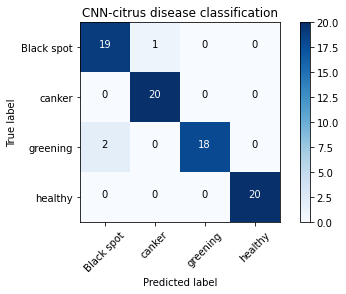

In [27]:
#predicting
Y_predictions = model.predict_generator(image_pred)
# predicted_class_indices has the predicted labels
Y_predicted_class_indices= np.argmax(Y_predictions,axis=1)

cm=confusion_matrix(image_pred.classes, Y_predicted_class_indices)

# Plot matrix for CNN
plot_confusion_matrix(cm, classes=classes,title='CNN-citrus disease classification')

plt.show()